<a href="https://colab.research.google.com/github/joanby/tensorflow2/blob/master/Collab%2012%20-%20Crear%20una%20API%20para%20Clasificar%20Imágenes%20con%20TensorFlow%20Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el proyecto en GPU


In [1]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [2]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  89181      0 --:--:-- --:--:-- --:--:-- 89181
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates In

In [3]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.10.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [2]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2022-11-02 16:33:58--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb.2’

tensorflow-model-se 100%[===================>] 319.88M   182MB/s    in 1.8s    

2022-11-02 16:34:00 (182 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb.2’ saved [335421916/335421916]

(Reading database ... 123943 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacking tensorflow-model-server-universal (2.8.0) ...
dpkg: error processing 

## Paso 2: Importar las dependencias del proyecto

In [4]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.9.2'

## Paso 3: Pre procesado de los datos

### Cargar el dataset

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
class_names = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

### Normalización de imágenes

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
X_train.shape

(50000, 32, 32, 3)

## Paso 4: Definir el modelo

NOTA: Vamos a usar el mismo modelo que creamos en la Sección de Redes Neuronales Convolucionales

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilar el modelo

In [10]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

###  Entrenar el modelo

In [11]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
391/391 [==============================] - 7s 11ms/step - loss: 1.5019 - sparse_categorical_accuracy: 0.4569
Epoch 2/10
391/391 [==============================] - 4s 11ms/step - loss: 1.0212 - sparse_categorical_accuracy: 0.6406
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 0.8288 - sparse_categorical_accuracy: 0.7095
Epoch 4/10
391/391 [==============================] - 4s 10ms/step - loss: 0.7077 - sparse_categorical_accuracy: 0.7555
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6110 - sparse_categorical_accuracy: 0.7881
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.5267 - sparse_categorical_accuracy: 0.8175
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 0.4482 - sparse_categorical_accuracy: 0.8456
Epoch 8/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3784 - sparse_categorical_accuracy: 0.8674
Epoch 9/10
391/391 [====================

### Evaluar el modelo

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.9217 - sparse_categorical_accuracy: 0.7437


In [13]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 74.37000274658203 %


## Paso 5: Guardar el modelo para subir a producción

### Crear un directorio para el modelo

In [14]:
MODEL_DIR = "model/"
version = 1

In [15]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [16]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Guardar el modelo para TensorFlow Serving

In [17]:
#tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})
#tf.saved_model.save(model, export_path )
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = model/1




Saved model:
total 204
drwxr-xr-x 2 root root   4096 Nov  2 16:27 assets
-rw-r--r-- 1 root root  20532 Nov  2 16:27 keras_metadata.pb
-rw-r--r-- 1 root root 174440 Nov  2 16:27 saved_model.pb
drwxr-xr-x 2 root root   4096 Nov  2 16:27 variables


## Paso 6: Configurar el entorno de producción

### Exportar el MODEL_DIR a las variables de entorno

In [18]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Ejecutar la API REST de TensorFlow Serving

In [19]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8000 \
  --model_name=cifar10 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [20]:
!tail server.log

tensorflow_model_server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by tensorflow_model_server)
tensorflow_model_server: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by tensorflow_model_server)
tensorflow_model_server: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by tensorflow_model_server)


## Paso 7: Crear nuestra primera petición por POST

In [23]:
random_image = np.random.randint(0, len(X_test))
random_image

9033

### Crear el objeto de datos en JSON

In [24]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [25]:
data

'{"signature_name": "serving_default", "instances": [[[[0.3686274509803922, 0.34901960784313724, 0.22745098039215686], [0.3686274509803922, 0.34901960784313724, 0.23137254901960785], [0.37254901960784315, 0.35294117647058826, 0.23137254901960785], [0.37254901960784315, 0.35294117647058826, 0.23137254901960785], [0.37254901960784315, 0.35294117647058826, 0.23529411764705882], [0.37254901960784315, 0.3568627450980392, 0.23137254901960785], [0.37254901960784315, 0.3568627450980392, 0.23137254901960785], [0.37254901960784315, 0.3568627450980392, 0.23529411764705882], [0.3764705882352941, 0.35294117647058826, 0.23529411764705882], [0.36470588235294116, 0.34901960784313724, 0.23137254901960785], [0.3568627450980392, 0.3568627450980392, 0.23529411764705882], [0.35294117647058826, 0.35294117647058826, 0.22745098039215686], [0.36470588235294116, 0.34901960784313724, 0.24313725490196078], [0.43529411764705883, 0.4196078431372549, 0.32941176470588235], [0.4980392156862745, 0.49411764705882355, 0.

### Enviar la primera petición POST al modelo

In [26]:
headers = {"content-type":"application/json"}

In [27]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

ConnectionError: ignored

In [ ]:
json_response

<Response [200]>

In [ ]:
predictions = json.loads(json_response.text)['predictions']

In [ ]:
predictions

[[0.000112434522,
  2.91902029e-06,
  0.049065,
  0.0013105449,
  0.732287228,
  0.000415284157,
  0.21677956,
  2.10254038e-05,
  1.86315174e-06,
  4.12425061e-06]]

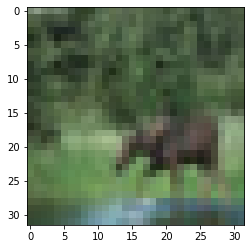

In [ ]:
plt.imshow(X_test[random_image])

In [ ]:
class_names[np.argmax(predictions[0])]

'ciervo'

## Paso 8: Enviar una petición POST a un modelo específico 

In [ ]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [ ]:
specific_json_response

<Response [200]>